In [2]:
import ee
import xarray as xr
import sys
import os
import pandas as pd
from datetime import datetime, timedelta
import math
import geemap
import glob
import logging
from tqdm import tqdm
import time
import re
import json

sys.path.append('G:/Other computers/My Laptop/ForGDRIVE/PLUME_work/PLUMES/earth-engine_SST_retrieval/SST_retrieval/modules')
import LANDSAT_SST

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [3]:
def load_in_landsat_collection(date_start, date_end):
    """
    Load and merge Landsat satellite image collections for a specified date range.

    Parameters:
    date_start (str): The start date in 'YYYY-MM-DD' format.
    date_end (str): The end date in 'YYYY-MM-DD' format.

    Returns:
    ee.ImageCollection: A sorted image collection containing Landsat 9, 8, 7, 5, and 4 images.
    """
    L9coll = LANDSAT_SST.collection('L9', date_start, date_end, validation=True)
    L8coll = LANDSAT_SST.collection('L8', date_start, date_end, validation=True)
    L7coll = LANDSAT_SST.collection('L7', date_start, date_end, validation=True)
    L5coll = LANDSAT_SST.collection('L5', date_start, date_end, validation=True)
    L4coll = LANDSAT_SST.collection('L4', date_start, date_end, validation=True)

    landsat_master_collection = L9coll
    landsat_master_collection = landsat_master_collection.merge(L8coll)
    landsat_master_collection = landsat_master_collection.merge(L7coll)
    landsat_master_collection = landsat_master_collection.merge(L5coll)
    landsat_master_collection = landsat_master_collection.merge(L4coll)

    landsat_master_collection = landsat_master_collection.sort('system:time_start')
    landsat_master_collection = landsat_master_collection.filterDate(date_start, date_end)
     
    return landsat_master_collection

def get_SST(feature):
    """
    Retrieve the mean Sea Surface Temperature (SST) from a Landsat image for a given feature.

    Parameters:
    feature (ee.Feature): The feature to check. It should have a 'TIME' property.

    Returns:
    ee.Feature: The input feature with an added 'SST' property, which is the mean SST value.
    """
    date = ee.Date(feature.get('TIME'))
    sdate = date.advance(-1, 'hour')
    edate = date.advance(1, 'hour')
    location = feature.geometry().buffer(100) # 100 m buffer

    image = load_in_landsat_collection('1980-01-01', '2024-12-01').filterBounds(location).filterDate(sdate, edate).first()
    SST = image.reduceRegion(ee.Reducer.mean(), location, 100).get('SST')
    A1 = image.reduceRegion(ee.Reducer.mean(), location, 100).get('A_coeff')
    B1 = image.reduceRegion(ee.Reducer.mean(), location, 100).get('B_coeff')
    C1 = image.reduceRegion(ee.Reducer.mean(), location, 100).get('C_coeff')
    brightness_temp = image.reduceRegion(ee.Reducer.mean(), location, 100).get('brightness_temp')
    em = image.reduceRegion(ee.Reducer.mean(), location, 100).get('emissivity')
    landsat_id = image.get('LANDSAT_PRODUCT_ID')

    return feature.set('SST', SST, 'A_coeff', A1, 'B_coeff', B1, 'C_coeff', C1, 'brightness_temp', brightness_temp, 'emissivity', em, 'LANDSAT_ID', landsat_id)

In [ ]:
landsat_collection = load_in_landsat_collection('2015-01-01', '2024-12-01')
# Define the point of interest
point_of_interest = ee.Geometry.Point(172.7695632, -43.5447910)
buffered_point = point_of_interest.buffer(30)  # 1 km buffer
filtered_collection = landsat_collection.filterBounds(buffered_point).filterDate('2015-01-01', '2024-12-01')
sorted_collection = filtered_collection.sort('system:time_start')

# Function to extract SST and metadata for each image
def extract_sst_data(image):
    reduction = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    )
    
    return image.set({
        'date': image.date().format('YYYY-MM-dd'),
        'SST': reduction.get('SST'),
        'satellite': image.get('SPACECRAFT_ID'),
        'cloud_cover': image.get('CLOUD_COVER')
    })

# Process the collection
sst_collection = landsat_collection.map(extract_sst_data)

# Get results as arrays
dates = sst_collection.aggregate_array('date').getInfo()
sst_values = sst_collection.aggregate_array('SST').getInfo()
satellites = sst_collection.aggregate_array('satellite').getInfo()
cloud_covers = sst_collection.aggregate_array('cloud_cover').getInfo()

list = list(zip(dates, sst_values, satellites, cloud_covers))

# Create DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'SST': sst_values,
    'satellite': satellites,
    'cloud_cover': cloud_covers
}).sort_values('date')

return df


Time series exported to sst_timeseries_2015_2024.csv


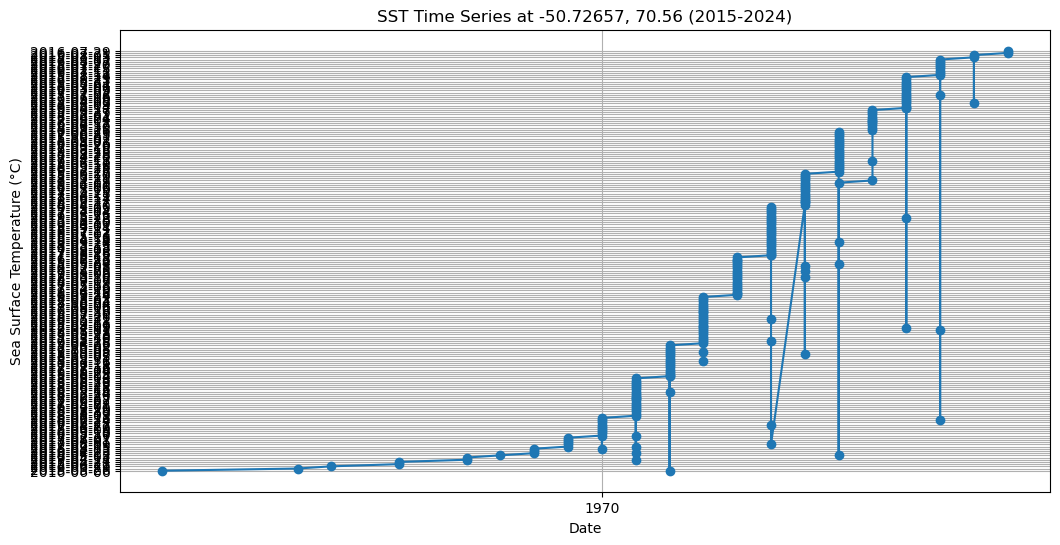

In [7]:
# for this point "-50.72657, 70.56" retrieve timeseries of SST from 2015-2024

# Load the Landsat collection for the specified date range
landsat_collection = load_in_landsat_collection('2015-01-01', '2024-12-01')

# Define the point of interest
point_of_interest = ee.Geometry.Point(-50.72657, 70.56)

# Create a buffer around the point
buffered_point = point_of_interest.buffer(30)  # 1 km buffer

# Filter the Landsat collection by date and location
filtered_collection = landsat_collection.filterBounds(buffered_point).filterDate('2015-01-01', '2024-12-01')
sorted_collection = filtered_collection.sort('system:time_start')

# reduce to time series using the mean and then export to csv
# Function to extract mean SST for each image
def extract_sst(image):
    # Reduce region to get mean SST
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffered_point,
        scale=30,  # Landsat resolution
        maxPixels=1e9
    )
    # Return image with mean SST and date properties
    return image.set({
        'date': image.date().format('YYYY-MM-dd'),
        'SST': mean_dict.get('SST')  # Assuming 'SST' is the band name
    })

# Map the function over the collection
sst_collection = sorted_collection.map(extract_sst)

# Get the time series as a list of dictionaries
sst = sst_collection.aggregate_array('SST').getInfo()
dates = sst_collection.aggregate_array('date').getInfo()

timeseries = list(zip(dates, sst))

# Convert to pandas DataFrame
import pandas as pd
df = pd.DataFrame(timeseries, columns=['SST', 'date'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Export to CSV
output_filename = 'sst_timeseries_2015_2024.csv'
df.to_csv(output_filename, index=False)
print(f'Time series exported to {output_filename}')

# Optional: Plot the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['SST'], 'o-')
plt.title('SST Time Series at -50.72657, 70.56 (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid(True)
plt.show()

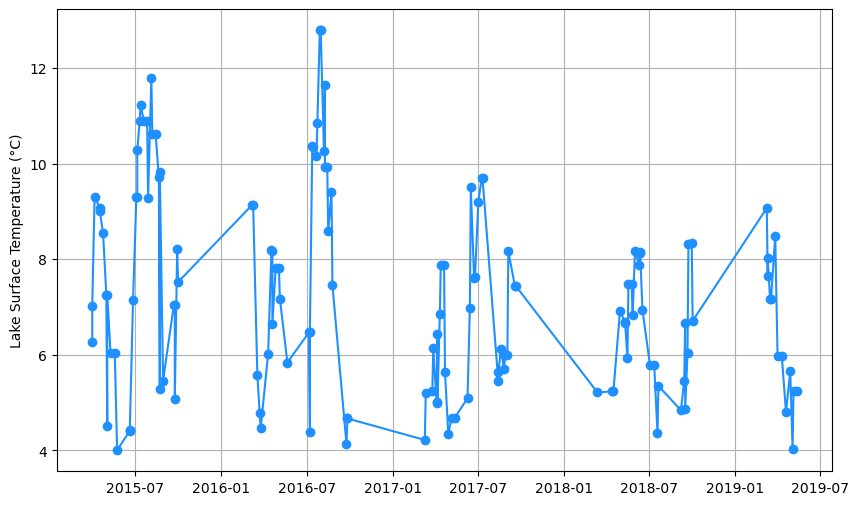

In [10]:
df = pd.DataFrame(timeseries, columns=['date', 'SST'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# CLIP TO JUST 2016
# df = df[(df['date'] >= '2016-07-01') & (df['date'] <= '2016-09-01')]
# removevalues that are less than 4
df = df[df['SST'] > 4]
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['SST'], 'o-', c='dodgerblue')
# plt.xlabel('2016')
plt.ylabel('Lake Surface Temperature (°C)')
plt.grid(True)
# format x-axis ticks to every month

plt.show()

In [14]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import geemap
import os

# Initialize Earth Engine
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

# Custom module import (assuming your LANDSAT_SST module is properly set up)
sys.path.append('G:/Other computers/My Laptop/ForGDRIVE/PLUME_work/PLUMES/earth-engine_SST_retrieval/SST_retrieval/modules')
import LANDSAT_SST

def load_landsat_collection(date_start, date_end):
    """Load and merge Landsat collections with cloud masking."""
    collections = []
    for satellite in ['L9', 'L8', 'L7', 'L5', 'L4']:
        coll = LANDSAT_SST.collection(satellite, date_start, date_end, validation=True)
        collections.append(coll)
    
    # Merge all collections
    master_collection = ee.ImageCollection(collections[0])
    for coll in collections[1:]:
        master_collection = master_collection.merge(coll)
    
    return master_collection.sort('system:time_start')

def get_sst_time_series(point, buffer_radius=100, start_year=2015, end_year=2025):
    """Retrieve SST time series for a specific point."""
    # Define the area of interest
    aoi = point.buffer(buffer_radius)
    
    # Load Landsat collection
    landsat_collection = load_landsat_collection(
        f'{start_year}-01-01', 
        f'{end_year}-12-31'
    ).filterBounds(aoi)
    
    # Function to extract SST and metadata for each image
    def extract_sst_data(image):
        reduction = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=30,
            maxPixels=1e9
        )
        
        return image.set({
            'date': image.date().format('YYYY-MM-dd'),
            'SST': reduction.get('SST'),
            'satellite': image.get('SPACECRAFT_ID'),
            'cloud_cover': image.get('CLOUD_COVER')
        })
    
    # Process the collection
    sst_collection = landsat_collection.map(extract_sst_data)
    
    # Get results as arrays
    dates = sst_collection.aggregate_array('date').getInfo()
    sst_values = sst_collection.aggregate_array('SST').getInfo()
    satellites = sst_collection.aggregate_array('satellite').getInfo()
    cloud_covers = sst_collection.aggregate_array('cloud_cover').getInfo()

    print('\ndates:', dates)
    print('\nsst_values:', sst_values)
    print('\nsatellites:', satellites)
    print('\ncloud_covers:', cloud_covers)
    list = list(zip(dates, sst_values, satellites, cloud_covers))

    df = pd.DataFrame(list, columns=['date', 'SST', 'satellite', 'cloud_cover'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    print(df.head())
    
    # # Create DataFrame
    # df = pd.DataFrame({
    #     'date': pd.to_datetime(dates),
    #     'SST': sst_values,
    #     'satellite': satellites,
    #     'cloud_cover': cloud_covers
    # }).sort_values('date')
    
    return df

def create_seasonal_maps(aoi, start_year=2015, end_year=2025):
    """Create seasonal average SST maps for the AOI."""
    # Define seasons
    seasons = {
        'Summer': ['12', '01', '02'],
        'Autumn': ['03', '04', '05'],
        'Winter': ['06', '07', '08'],
        'Spring': ['09', '10', '11']
    }
    
    # Load Landsat collection
    full_collection = load_landsat_collection(
        f'{start_year}-01-01', 
        f'{end_year}-12-31'
    ).filterBounds(aoi)
    
    seasonal_maps = {}
    
    for season_name, months in seasons.items():
        # Filter collection by season
        seasonal_filter = ee.Filter.calendarRange(
            int(months[0]), 
            int(months[-1]), 
            'month'
        )
        season_collection = full_collection.filter(seasonal_filter)
        
        # Calculate mean SST
        mean_sst = season_collection.select('SST').mean()
        
        # Clip to AOI
        seasonal_maps[season_name] = mean_sst.clip(aoi)
    
    return seasonal_maps

def main():
    # Define Christchurch coastal point (near Banks Peninsula)
    christchurch_coast = ee.Geometry.Point(172.75, -43.55)  # Approximate coastal location
    
    # 1. Get time series data
    print("Retrieving SST time series...")
    sst_df = get_sst_time_series(christchurch_coast)
    
    # Save to CSV
    sst_df.to_csv('christchurch_sst_2015_2025.csv', index=False)
    print("Time series saved to christchurch_sst_2015_2025.csv")
    
    # Plot time series
    plt.figure(figsize=(15, 6))
    plt.plot(sst_df['date'], sst_df['SST'], 'o-', markersize=3)
    plt.title('Sea Surface Temperature near Christchurch (2015-2025)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.savefig('christchurch_sst_timeseries.png')
    plt.show()
    
    # 2. Create seasonal maps
    print("Creating seasonal maps...")
    # Define larger AOI for the maps (100km buffer around our point)
    map_aoi = christchurch_coast.buffer(100e3)  # 100km buffer
    
    seasonal_maps = create_seasonal_maps(map_aoi)
    
    # Visualize and save seasonal maps
    for season, image in seasonal_maps.items():
        print(f"Processing {season} map...")
        
        # Create visualization parameters
        vis_params = {
            'bands': 'SST',
            'min': 8,  # Adjust based on your data
            'max': 22,  # Adjust based on your data
            'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
        }
        
        # Create map
        Map = geemap.Map()
        Map.addLayer(image, vis_params, f'{season} Average SST')
        Map.addLayer(map_aoi, {'color': 'white'}, 'AOI', False)
        Map.centerObject(christchurch_coast, 9)
        
        # Save map
        output_file = f'christchurch_{season.lower()}_sst_map.html'
        Map.save(output_file)
        print(f"Saved {season} map to {output_file}")

if __name__ == '__main__':
    main()

Retrieving SST time series...

dates: ['2015-01-02', '2015-01-03', '2015-01-10', '2015-01-11', '2015-01-18', '2015-01-19', '2015-01-26', '2015-01-27', '2015-02-03', '2015-02-04', '2015-02-11', '2015-02-12', '2015-02-19', '2015-02-20', '2015-02-27', '2015-02-28', '2015-03-07', '2015-03-08', '2015-03-15', '2015-03-16', '2015-03-23', '2015-03-24', '2015-03-31', '2015-04-01', '2015-04-08', '2015-04-09', '2015-04-16', '2015-04-17', '2015-04-24', '2015-04-25', '2015-05-02', '2015-05-03', '2015-05-10', '2015-05-11', '2015-05-18', '2015-05-19', '2015-05-26', '2015-05-27', '2015-06-03', '2015-06-04', '2015-06-11', '2015-06-12', '2015-06-19', '2015-06-20', '2015-06-27', '2015-06-28', '2015-07-05', '2015-07-06', '2015-07-13', '2015-07-21', '2015-07-22', '2015-07-29', '2015-07-30', '2015-08-06', '2015-08-07', '2015-08-14', '2015-08-22', '2015-08-23', '2015-08-30', '2015-09-07', '2015-09-08', '2015-09-15', '2015-09-23', '2015-09-24', '2015-10-01', '2015-10-02', '2015-10-09', '2015-10-10', '2015-10-

UnboundLocalError: cannot access local variable 'list' where it is not associated with a value

In [15]:
print('\ndates:', dates)
print('\nsst_values:', sst_values)
print('\nsatellites:', satellites)
print('\ncloud_covers:', cloud_covers)
list = list(zip(dates, sst_values, satellites, cloud_covers))

df = pd.DataFrame(list, columns=['date', 'SST', 'satellite', 'cloud_cover'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print(df.head())


dates: ['2015-03-16', '2015-03-16', '2015-03-23', '2015-03-30', '2015-04-01', '2015-04-01', '2015-04-06', '2015-04-17', '2015-04-17', '2015-04-22', '2015-04-24', '2015-05-01', '2015-05-03', '2015-05-03', '2015-05-10', '2015-05-19', '2015-05-24', '2015-05-26', '2015-06-02', '2015-06-04', '2015-06-04', '2015-06-09', '2015-06-11', '2015-06-18', '2015-06-20', '2015-06-20', '2015-06-25', '2015-06-27', '2015-07-04', '2015-07-06', '2015-07-06', '2015-07-11', '2015-07-13', '2015-07-20', '2015-07-27', '2015-07-29', '2015-08-05', '2015-08-07', '2015-08-07', '2015-08-14', '2015-08-21', '2015-08-23', '2015-08-23', '2015-08-30', '2015-09-06', '2015-09-08', '2015-09-08', '2015-09-13', '2015-09-22', '2015-09-24', '2015-09-24', '2015-09-29', '2015-10-01', '2016-03-07', '2016-03-09', '2016-03-16', '2016-03-18', '2016-03-23', '2016-03-25', '2016-04-01', '2016-04-03', '2016-04-03', '2016-04-10', '2016-04-17', '2016-04-19', '2016-04-19', '2016-04-26', '2016-05-03', '2016-05-05', '2016-05-05', '2016-05-10

NameError: name 'sst_values' is not defined

In [5]:
# For this point "-50.72657, 70.56" retrieve timeseries of SST from 2015-2024

# Load the Landsat collection for the specified date range
landsat_collection = load_in_landsat_collection('2015-01-01', '2024-12-01')

# Define the point of interest
point_of_interest = ee.Geometry.Point(-50.72657, 70.56)

# Create a buffer around the point (30 meters is ~1 Landsat pixel, adjust as needed)
buffered_point = point_of_interest.buffer(30)  # 30m buffer

# Filter the Landsat collection by date and location
filtered_collection = landsat_collection.filterBounds(buffered_point).filterDate('2015-01-01', '2024-12-01')
sorted_collection = filtered_collection.sort('system:time_start')

# Function to extract mean SST for each image
def extract_sst(image):
    # Reduce region to get mean SST
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffered_point,
        scale=30,  # Landsat resolution
        maxPixels=1e9
    )
    # Return image with mean SST and date properties
    return image.set({
        'date': image.date().format('YYYY-MM-dd'),
        'SST': mean_dict.get('SST')  # Assuming 'SST' is the band name
    })

# Map the function over the collection
sst_collection = sorted_collection.map(extract_sst)

# Get the time series as a list of dictionaries
sst = sst_collection.aggregate_array('SST').getInfo()
dates = sst_collection.aggregate_array('date').getInfo()
# Combine dates and SST values into a list of tuples
timeseries = list(zip(dates, timeseries))

# Convert to pandas DataFrame
import pandas as pd
df = pd.DataFrame(timeseries, columns=['SST', 'date'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Export to CSV
output_filename = 'sst_timeseries_2015_2024.csv'
df.to_csv(output_filename, index=False)
print(f'Time series exported to {output_filename}')

# Optional: Plot the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['SST'], 'o-')
plt.title('SST Time Series at -50.72657, 70.56 (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid(True)
plt.show()

NameError: name 'timeseries' is not defined

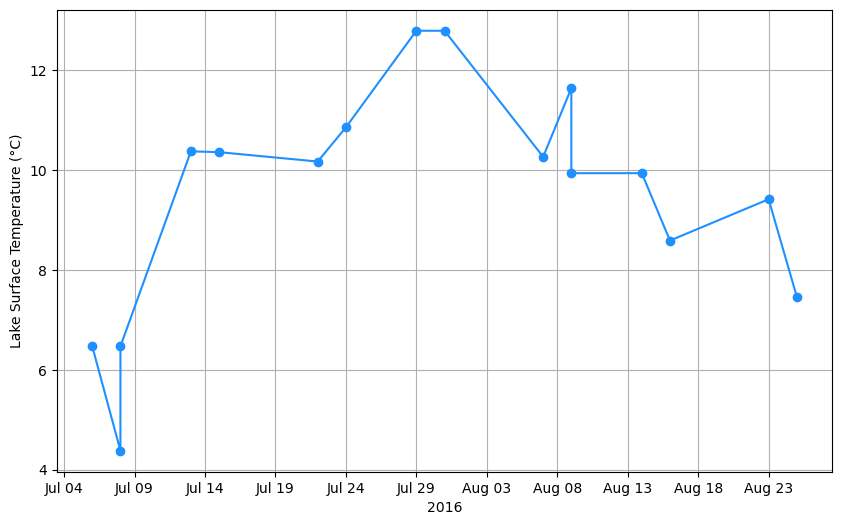

In [ ]:
df = pd.DataFrame(timeseries, columns=['date', 'SST'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# CLIP TO JUST 2016
df = df[(df['date'] >= '2016-07-01') & (df['date'] <= '2016-09-01')]
# removevalues that are less than 4
df = df[df['SST'] > 4]
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['SST'], 'o-', c='dodgerblue')
plt.xlabel('2016')
plt.ylabel('Lake Surface Temperature (°C)')
plt.grid(True)
# format x-axis ticks to show month and day %b %d every 2 weeks
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=5))
plt.show()

In [ ]:
# timeseries


# # Convert to pandas DataFrame
# import pandas as pd
# df = pd.DataFrame(timeseries, columns=['SST', 'date'])
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values('date')

# # Export to CSV
# output_filename = 'sst_timeseries_2015_2024.csv'
# df.to_csv(output_filename, index=False)
# print(f'Time series exported to {output_filename}')

# # Optional: Plot the time series
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.plot(df['date'], df['SST'], 'o-')
# plt.title('SST Time Series at -50.72657, 70.56 (2015-2024)')
# plt.xlabel('Date')
# plt.ylabel('Sea Surface Temperature (°C)')
# plt.grid(True)
# plt.show()

[('2015-03-16', 2.256410739037191),
 ('2015-03-16', 3.752950309625124),
 ('2015-03-23', 3.268335110899689),
 ('2015-03-30', 3.270339168743511),
 ('2015-04-01', 6.27766407595023),
 ('2015-04-01', 7.021987126964491),
 ('2015-04-06', 9.30774210578368),
 ('2015-04-17', 9.074964689950319),
 ('2015-04-17', 9.009128209462824),
 ('2015-04-22', -6.03921286892264),
 ('2015-04-24', 8.552278146921505),
 ('2015-05-01', 7.25458985370188),
 ('2015-05-03', 7.254223431371919),
 ('2015-05-03', 4.512927919234025),
 ('2015-05-10', 6.0390097451783),
 ('2015-05-19', 6.0401218219512),
 ('2015-05-24', 4.003455731291221),
 ('2015-05-26', -9.941629683800898),
 ('2015-06-02', 2.923761839664094),
 ('2015-06-04', 2.9194510021550473),
 ('2015-06-04', 2.287457226769872),
 ('2015-06-09', 0.4374365202916501),
 ('2015-06-11', -6.074039933903687),
 ('2015-06-18', 2.777929508046726),
 ('2015-06-20', 4.4109620291814435),
 ('2015-06-20', 4.436717930398149),
 ('2015-06-25', 1.1256016290048398),
 ('2015-06-27', 7.14725405526